In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping 
from keras_bert import gelu
import os
import datetime
import io
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np


class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(200)

opt = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)



class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        print(maxlen)
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


#parameters = {"num_of_bases_before_CDS" : num_of_bases_before_CDS , "prom_crop": prom_crop, "embed_dim" : embed_dim, "num_heads" : num_heads, "ff_dim" : ff_dim, "maxlen" : maxlen, "vocab_size" : vocab_size,  "NUM_LAYERS" : NUM_LAYERS, "optimizer" : optimizer, "Transformer_embed_dim" : Transformer_embed_dim ,  "Transformer_rate" : Transformer_rate, "conv_layer_params" : conv_layer_params, "conv_layer_params2" : conv_layer_params2,  "conv_layer_params3" : conv_layer_params3, "Dropout_param1": Dropout_param1, "Dropout_param2" : Dropout_param2, "Dense_param" : Dense_param, "amountOfbases" : amountOfbases, "cropfrombehind" : cropfrombehind }


def model(num_of_bases_before_CDS = None, prom_crop = None, embed_dim = None, num_heads = None, ff_dim = None, maxlen = None, vocab_size = None, NUM_LAYERS = None, optimizer = None, Transformer_embed_dim = None, Transformer_rate = None, conv_layer_params = None, conv_layer_params2 = None, conv_layer_params3 = None,Dropout_param1 = None,Dropout_param2 = None,Dense_param = None,amountOfbases = None, cropfrombehind = None):

    if optimizer == 'custom':
        optimizer = opt

    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)

    x = embedding_layer(inputs)
    conv_layer = layers.Conv1D(filters = conv_layer_params[0],kernel_size=conv_layer_params[1], strides=conv_layer_params[2], padding="same", activation= gelu )
    if conv_layer_params2[0] != "X":
        conv_layer2 = layers.Conv1D(filters = conv_layer_params2[0],kernel_size=conv_layer_params2[1], strides=conv_layer_params2[2], padding="same", activation= gelu )
    conv_layer3 = layers.Conv1D(filters = conv_layer_params3[0],kernel_size=conv_layer_params3[1], strides=conv_layer_params3[2], padding="same", activation= gelu )

    #conv_layer4  = layers.Conv1D(filters = 200,kernel_size=8, strides=7, padding="same", activation= gelu)
    #conv_layer5  = layers.Conv1D(filters = 200,kernel_size=8, strides=7, padding="same", activation= gelu)
    #transformer_block = TransformerBlock(200, num_heads, ff_dim, rate=0.2)
    #transformer_block2 = TransformerBlock2(100, num_heads, ff_dim, rate=0.2)



    x = conv_layer(x)
    if conv_layer_params2[0] != "X":
        x = conv_layer2(x)
    x = conv_layer3(x)
    #x = conv_layer4(x)
    #x = conv_layer5(x)
    for _ in range(NUM_LAYERS):
        x = TransformerBlock(Transformer_embed_dim, num_heads, ff_dim, rate=Transformer_rate)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(Dropout_param1)(x)
    x = layers.Dense(Dense_param, activation="relu")(x)
    x = layers.Dropout(Dropout_param2)(x)

    outputs = layers.Dense(3, activation="softmax")(x)

    #categorical_crossentropy
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=["sparse_categorical_accuracy"])
    #model.summary()
    return model

In [25]:
param = load_model_param()
model = model(**param)

{'num_of_bases_before_CDS': 300, 'prom_crop': True, 'embed_dim': 200, 'num_heads': 4, 'ff_dim': 200, 'maxlen': 300, 'vocab_size': 4, 'NUM_LAYERS': 4, 'optimizer': 'adam', 'Transformer_embed_dim': 100, 'Transformer_rate': 0.2, 'conv_layer_params': [100, 2, 1], 'conv_layer_params2': ['X', 'X', 'X'], 'conv_layer_params3': [100, 7, 6], 'Dropout_param1': 0.2, 'Dropout_param2': 0.2, 'Dense_param': 20, 'amountOfbases': 300}
Tensor("token_and_position_embedding/strided_slice:0", shape=(), dtype=int32)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 token_and_position_embeddin  (None, 300, 200)         60800     
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                        

In [3]:
import os
import re
import ast
import json

def load_model_param(folder):
    rootdir = "./metalogs/logs/fit/"
    with open(rootdir +  folder+ "/parameters.txt", "r") as file:
        a = file.readlines()
        try:
            param = ast.literal_eval(a[0])
        except:
            a[0] = a[0].replace("<keras.optimizer_v2.adam.Adam object at 0x15093e18cbe0>", "'custom'")
            print(a[0])
            param = ast.literal_eval(a[0])

    embed_dim = 300  # Embedding size for each token
    num_heads =2 # Number of attention heads
    ff_dim = 300
    vocab_size = 4
    NUM_LAYERS = 2
    Transformer_embed_dim = 100
    Transformer_rate = 0.2
    optimizer = "adam"
    conv_layer_params = [200, 2, 1]
    conv_layer_params2 = ['X', 'X', 'X']
    conv_layer_params3 = [100,7,6]
    Dropout_param1 = 0.6
    Dropout_param2 = 0.6
    Dense_param = 80
    num_of_bases_before_CDS = 1000
    prom_crop = True
    amountOfbases = 300
    maxlen = amountOfbases
    step = amountOfbases
    cropfrombehind = False

    return param
    



In [38]:
for key in dirs_with_data.keys():
    param = load_model_param(key)
    print(param["optimizer"])

adam
adam
adam
adam
adam
adam
adam
adam
adam
adam
adam
{'num_of_bases_before_CDS': 1000, 'prom_crop': True, 'embed_dim': 300, 'num_heads': 2, 'ff_dim': 300, 'maxlen': 300, 'vocab_size': 4, 'NUM_LAYERS': 2, 'optimizer': 'custom', 'Transformer_embed_dim': 100, 'Transformer_rate': 0.2, 'conv_layer_params': [200, 2, 1], 'conv_layer_params2': ['X', 'X', 'X'], 'conv_layer_params3': [100, 7, 6], 'Dropout_param1': 0.6, 'Dropout_param2': 0.6, 'Dense_param': 80, 'amountOfbases': 300, 'cropfrombehind': True}
custom


{'num_of_bases_before_CDS': 300, 'prom_crop': True, 'embed_dim': 200, 'num_heads': 4, 'ff_dim': 200, 'maxlen': 300, 'vocab_size': 4, 'NUM_LAYERS': 4, 'optimizer': 'adam', 'Transformer_embed_dim': 100, 'Transformer_rate': 0.2, 'conv_layer_params': [100, 2, 1], 'conv_layer_params2': ['X', 'X', 'X'], 'conv_layer_params3': [100, 7, 6], 'Dropout_param1': 0.2, 'Dropout_param2': 0.2, 'Dense_param': 20, 'amountOfbases': 300}
Tensor("token_and_position_embedding_4/strided_slice:0", shape=(), dtype=int32)
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 300)]             0         
                                                                 
 token_and_position_embeddin  (None, 300, 200)         60800     
 g_4 (TokenAndPositionEmbedd                                     
 ing)                                                            
                    

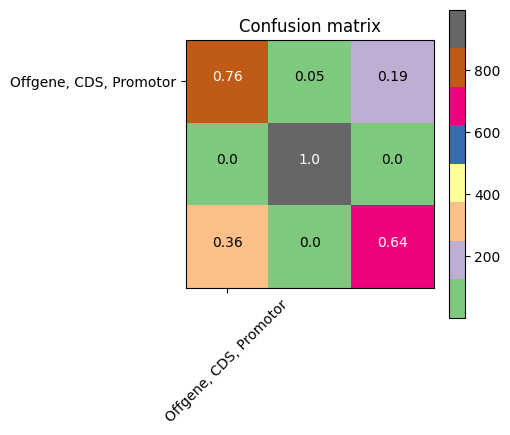

In [11]:
file = "E:/VYSOKA/BAKA/metalogs/logs/fit/20230807-020928-300-300/my_model_weights.h5"
param = load_model_param()
NNmodel = model(**param)
NNmodel.load_weights(file)
locals().update(param)


94/94 [==============================] - 1s 8ms/step
[[757  54 189]
 [  4 995   1]
 [356   5 639]]
3


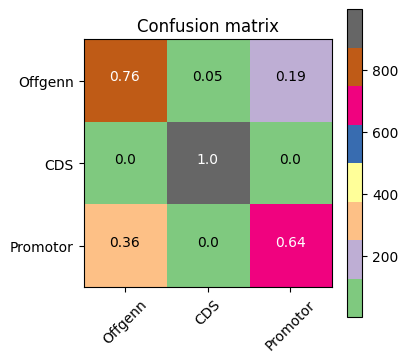

In [17]:
log_confusion_matrix(NNmodel)

In [17]:
class_names = ["Offgene", "CDS", "Promotor"] 
def log_confusion_matrix(model, path):
    predictions = model.predict(X_test)
    predictions = np.argmax(predictions, axis=1)

    cm = metrics.confusion_matrix(y_test, predictions)
    figure = plot_confusion_matrix(cm, class_names=class_names)
    figure.savefig(path + "confmatrix1.svg", bbox_inches='tight')
    #cm_image = plot_to_image(figure)

import itertools
def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(4, 4))
    plt.imshow(cm, cmap=plt.cm.Accent)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    print(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    threshold = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    return figure

        
def plot_to_image(figure):
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)

    digit = tf.image.decode_png(buf.getvalue(), channels=4)
    digit = tf.expand_dims(digit, 0)

    return digit

In [7]:
def load_valData(num_of_bases_before_CDS, step, amountOfbases):
    OffgeneData_val = load_seq_to_list("./Val_Data/FiltredAllValOffgeneSeq" + str(num_of_bases_before_CDS) + ".fsa", amountOfbases, step=step)
    CDS_Data_val = load_seq_to_list("./Val_Data/FiltredAllValCDSeq.fsa",amountOfbases, step=step)
    PromData_val = load_seq_to_list("./Val_Data/FiltredAllValPromotorSeq" + str(num_of_bases_before_CDS) + ".fsa", amountOfbases, True, step=step)
    
    return CDS_Data_val, OffgeneData_val, PromData_val

import string
import os
import fastaparser
import random
from heapq import nlargest


alphabet = list(string.ascii_letters)
alphabet.remove("A")
alphabet.remove("C")
alphabet.remove("G")
alphabet.remove("T")
alphabet.remove("a")
alphabet.remove("c")
alphabet.remove("g")
alphabet.remove("t")
def load_seq_to_list(file, amountOfbases, prom_crop_out = False, step=300):
    seqList = []
    with open(file,"r") as f:
        parser = fastaparser.Reader(f, parse_method='quick')
        #parser = shuffle(parser, 1)
        for s in parser:
            seq = s.sequence
            if prom_crop_out:
                if 'Promotor' in file:
                    if s.header.split(" ")[2] == "n" : start = 1
                    else: start = len(s.sequence) - int(s.header.split(" ")[2]) 
                    seq = seq[start-1:]
                    seq = seq[::-1]
            i = 0
            while i + amountOfbases < len(seq) + 1:
                for letter in alphabet:
                    if letter in seq[i:i + amountOfbases]: continue
                if "Promotor" in file:
                    seqtoappend = seq[i:i + amountOfbases]
                    seqList.append(seqtoappend[::-1])
                else:
                    seqList.append(seq[i:i + amountOfbases])
                i += step
    
    return seqList


def get_test(CDS_Data, PromData, OffgeneData):
    cds_len = len(CDS_Data)
    Prom_len = len(PromData)
    Offgene_len = len(OffgeneData)
    X_val = []
    y_val = []
    for i in range(0,1000):
        random_postion = random.randint(0, len(X_val) + 1)
        X_val.insert(random_postion, [toNumbers(x) for x in OffgeneData[i%Offgene_len]])
        y_val.insert(random_postion, 0)
        random_postion = random.randint(0, len(X_val) + 1)
        X_val.insert(random_postion, [toNumbers(x) for x in CDS_Data[i%cds_len]])
        y_val.insert(random_postion, 1)
        random_postion = random.randint(0, len(X_val) + 1)
        X_val.insert(random_postion, [toNumbers(x) for x in PromData[i%Prom_len]])
        y_val.insert(random_postion, 2)
    
    X_val = np.asarray(X_val, dtype=np.int32)
    y_val = np.asarray(y_val, dtype=np.int32).reshape((-1,1))
    
    return X_val, y_val


def toNumbers(letter):
    switcher = {
        "A": 0,
        "T": 1,
        "C": 2,
        "G": 3,
        "a": 0,
        "t": 1,
        "c": 2,
        "g": 3,
        }   
    return switcher.get(letter,0)

def get_data(amountOfbases, num_of_bases_before_CDS):
    step = amountOfbases
    CDS_Data_val, OffgeneData_val, PromData_val= load_valData(num_of_bases_before_CDS, step, amountOfbases)
    X_test, y_test = get_test(CDS_Data_val[-1000:], PromData_val[-1000:], OffgeneData_val[-1000:])
    return X_test, y_test

In [29]:
import os
import re

rootdir = "./metalogs/logs/fit/"
regex = re.compile('202308[0|1][7-9|0]')
dirs_with_data = {}


for dir in os.listdir(rootdir):
    if regex.match(dir):
       dirs_with_data[dir] = []

for key in dirs_with_data.keys():
    for file in os.listdir(rootdir + key):
        if "h5" in file:
            dirs_with_data[key].append(file)

for key in dirs_with_data.keys():
    for file in os.listdir(rootdir + key):
        if "parameters" in file:
            dirs_with_data[key].append(file)

emmpty_keys = []
for key in dirs_with_data.keys():
        if len(dirs_with_data[key]) < 2:
             emmpty_keys.append(key)
        
for key in emmpty_keys:
     dirs_with_data.pop(key)
print(dirs_with_data)


{'20230807-020928-300-300': ['my_model_weights.h5', 'parameters.txt'], '20230807-121358-300-200': ['my_model_weights.h5', 'parameters.txt'], '20230808-174331-1000-300': ['my_model_weights.h5', 'parameters.txt'], '20230808-210115-1000-300': ['my_model_weights.h5', 'parameters.txt'], '20230808-212720-1000-300': ['my_model_weights.h5', 'parameters.txt'], '20230808-233132-1000-300': ['my_model_weights.h5', 'parameters.txt'], '20230809-014523-1000-300': ['my_model_weights.h5', 'parameters.txt'], '20230809-102750-1000-300': ['my_model_weights.h5', 'parameters.txt'], '20230809-124738-1000-300': ['my_model_weights.h5', 'parameters.txt'], '20230809-152939-1000-300': ['my_model_weights.h5', 'parameters.txt'], '20230809-174634-1000-300': ['my_model_weights.h5', 'parameters.txt'], '20230810-004947-1000-300': ['my_model_weights.h5', 'parameters.txt']}


20230810-004947-1000-300
{'num_of_bases_before_CDS': 1000, 'prom_crop': True, 'embed_dim': 300, 'num_heads': 2, 'ff_dim': 300, 'maxlen': 300, 'vocab_size': 4, 'NUM_LAYERS': 2, 'optimizer': 'custom', 'Transformer_embed_dim': 100, 'Transformer_rate': 0.2, 'conv_layer_params': [200, 2, 1], 'conv_layer_params2': ['X', 'X', 'X'], 'conv_layer_params3': [100, 7, 6], 'Dropout_param1': 0.6, 'Dropout_param2': 0.6, 'Dense_param': 80, 'amountOfbases': 300, 'cropfrombehind': True}
Tensor("token_and_position_embedding_19/strided_slice:0", shape=(), dtype=int32)
Tensor("model_19/token_and_position_embedding_19/strided_slice:0", shape=(), dtype=int32)
94/94 [==============================] - 1s 5ms/step
3


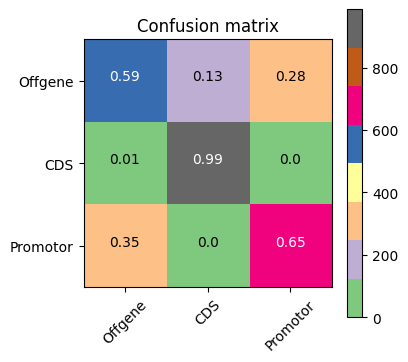

In [27]:
for key in dirs_with_data.keys():
    file = "E:/VYSOKA/BAKA/metalogs/logs/fit/" + key + "/my_model_weights.h5"
    path = "E:/VYSOKA/BAKA/metalogs/logs/fit/" + key + "/"
    print(key)
    param = load_model_param(key)
    locals().update(param)
    NNmodel = model(**param)
    try:
        NNmodel.load_weights(file)
        X_test, y_test = get_data(amountOfbases, num_of_bases_before_CDS)
        log_confusion_matrix(NNmodel, path)
    except:
        print("ERROR: ",key)
        continue

20230807-020928-300-300
Tensor("token_and_position_embedding_6/strided_slice:0", shape=(), dtype=int32)
Tensor("model_6/token_and_position_embedding_6/strided_slice:0", shape=(), dtype=int32)
94/94 [==============================] - 1s 9ms/step
3
20230807-121358-300-200
Tensor("token_and_position_embedding_7/strided_slice:0", shape=(), dtype=int32)


ValueError: Layer count mismatch when loading weights from file. Model expected 12 layers, found 11 saved layers.

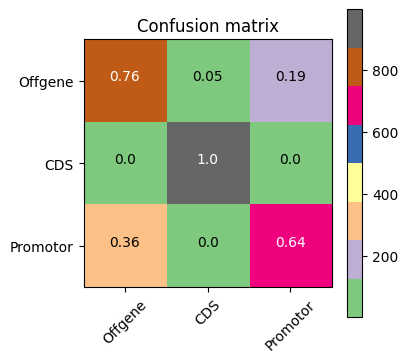

In [22]:
for key in dirs_with_data.keys():
    file = "E:/VYSOKA/BAKA/metalogs/logs/fit/" + key + "/my_model_weights.h5"
    path = "E:/VYSOKA/BAKA/metalogs/logs/fit/" + key + "/"
    print(key)
    param = load_model_param(key)
    locals().update(param)
    NNmodel = model(**param)
    NNmodel.load_weights(file)
    X_test, y_test = get_data(amountOfbases, num_of_bases_before_CDS)
    log_confusion_matrix(NNmodel, path)
    continue

In [28]:

def plotgraph(key, path):
   df = pd.read_csv('./csvfiles/'+ key + '_train.csv')
   df2 = pd.read_csv('./csvfiles/'+ key + '_validation.csv')
   df = df.drop(columns=["Wall time"])
   df = df.rename(columns={"Value": "Trenovani"})
   df2 = df2.drop(columns=["Wall time"])
   df2 = df2.drop(columns=["Step"])
   df2 = df2.rename(columns={"Value": "Validace"})
   frames = [df, df2]
   result = pd.concat([df, df2], axis=1, join="inner")
   fig = px.line(result, x = 'Step', y = ["Trenovani", "Validace"], title='Přensost modelu').update_layout(xaxis_title="Epocha", yaxis_title="Přesnost")
   print(key)
   fig.write_image(path + key+".svg")

import pandas as pd
import pandas as pd
import plotly.express as px
for key in dirs_with_data.keys():
    file = "E:/VYSOKA/BAKA/metalogs/logs/fit/" + key + "/my_model_weights.h5"
    path = "E:/VYSOKA/BAKA/metalogs/logs/fit/" + key + "/"
    plotgraph(key, path)




20230810-004947-1000-300


In [32]:
def napismiparametry(folder):
    param = load_model_param(folder)
    for k, v in param.items():
        print("\item ",k , v)


for key in dirs_with_data.keys():
    print(key)
    napismiparametry(key)

20230807-020928-300-300
\item  num_of_bases_before_CDS 300
\item  prom_crop True
\item  embed_dim 200
\item  num_heads 4
\item  ff_dim 200
\item  maxlen 300
\item  vocab_size 4
\item  NUM_LAYERS 4
\item  optimizer adam
\item  Transformer_embed_dim 100
\item  Transformer_rate 0.2
\item  conv_layer_params [100, 2, 1]
\item  conv_layer_params2 ['X', 'X', 'X']
\item  conv_layer_params3 [100, 7, 6]
\item  Dropout_param1 0.2
\item  Dropout_param2 0.2
\item  Dense_param 20
\item  amountOfbases 300
20230807-121358-300-200
\item  num_of_bases_before_CDS 300
\item  prom_crop True
\item  embed_dim 200
\item  num_heads 8
\item  ff_dim 300
\item  maxlen 200
\item  vocab_size 4
\item  NUM_LAYERS 6
\item  optimizer adam
\item  Transformer_embed_dim 100
\item  Transformer_rate 0.2
\item  conv_layer_params [200, 2, 1]
\item  conv_layer_params2 [200, 5, 4]
\item  conv_layer_params3 [100, 7, 6]
\item  Dropout_param1 0.2
\item  Dropout_param2 0.2
\item  Dense_param 20
\item  amountOfbases 200
20230808-174

<>:4: DeprecationWarning:

invalid escape sequence \i

<>:4: DeprecationWarning:

invalid escape sequence \i

C:\Users\kajap\AppData\Local\Temp\ipykernel_31816\3550779327.py:4: DeprecationWarning:

invalid escape sequence \i

